# Исследование надежности заемщиков.

### Шаг 1. Обзор данных <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
data = pd.read_csv('data_project_2.csv')
display(data.tail(5))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля
21524,2,-1984.507589,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля


### Шаг 2.1 Заполнение пропусков

In [2]:
data.info() # Просмотрим информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Не нулевые значения, отличные от 21525 (длина датафрейма), имеют два столбца:

1. `days_employed`
2. `total_income`.

Рассмотрим их подробнее:

In [3]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Количество пропусков:
display(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [4]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Доля пропусков
display(data.isna().mean())

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

In [5]:
medianna = data['total_income'].median()
# нашли медианное значение по столбцу 'total_income'
data['total_income'] = data['total_income'].fillna(medianna)
# заполнили пустые ячейки медианными значениями

Просмотри число медианных значение в столбце `total_income`

In [6]:
display(data['total_income'].value_counts().head(5))

145017.937533    2175
112874.418757       1
104381.857170       1
182036.676828       1
122421.963500       1
Name: total_income, dtype: int64

Из вывода видно: 2174 ячейки пустые + одно медианное значение. 
Похоже, что пустыя ячейки в столбце `total_income` совпадают с пустыми ячейками в столбце `days_employed`. Проверим предположение:

In [7]:
unique_value = data[data['total_income'] == medianna]['days_employed'].unique()
display(unique_value)

array([          nan, -341.40009236])

Видим, всего два значения в столбце `days_employed` для медианных значений в столбце `total_income`. Проверим: какие значения останутся в `unique_value` исключив `unique_value[1]` из столбца `days_emloyed` (-341.40009236):

In [8]:
unique_value = data.loc[
    (data['total_income'] == medianna) & (data['days_employed'] != unique_value[1]),
    'days_employed'].unique()
display(unique_value)

array([nan])

Пустой `array` доказывает совпадение пустых ячеек в столбце `days_employed` с пустыми ячейками в `total_income`.
Если столбцы total_income и days_employed имеют пропуски строго в одних и тех же строках, значит если человек не работал ни дня, его доход отсутствует. В то же время, для этих строк указан тип занятости. Можно предположить, что человек пришёл за кредитом в первый день занятости.

Пустые значения столбца `total_income` следует заполнить не нулевыми значениями -- на нулевой доход и кредит будет нулевой. В первом приближении выбор стоит между средним и медианным значениями по столбцу. Так как в выборке могут быть выдающиеся значения, лучше использовать медианну.

### Шаг 2.2 Проверка данных на аномалии и исправления.

Из предыдущего пункта видно: в столбце `days_employed` содержатся данные типа
float, но некоторые из них отрицательные - это неправдоподобно для трудового 
стажа в днях. 

#### Проверка столбцов с числовыми значениями и их устранение

##### Проверка столбца `days_emloyed`

In [9]:
# Оценим количество отрицательных значений в столбце:
display(data.loc[data['days_employed'] < 0, 'days_employed'].sort_values())

16335   -18388.949901
4299    -17615.563266
7329    -16593.472817
17838   -16264.699501
16825   -16119.687737
             ...     
2127       -34.701045
9683       -33.520665
6157       -30.195337
8336       -24.240695
17437      -24.141633
Name: days_employed, Length: 15906, dtype: float64

Отрицательных значений около 75% от всех значений - на мой взгляд слишком высока часть отрицательных значений для человеческого фактора и больше похоже на технологическую ошибку, т.е. по ошибке был приписан "-" к числу. Задача: убрать минус.

In [10]:
# Возьмём все значения столбца по модулю
data['days_employed'] = data['days_employed'].apply(abs) 
# Проверим на отрицательные значения:
display(data.loc[data['days_employed'] <= 0, 'days_employed'])

Series([], Name: days_employed, dtype: float64)

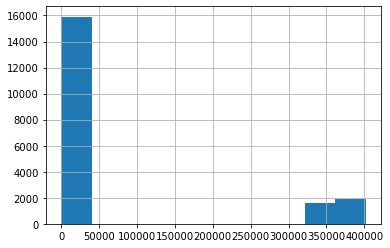

In [11]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Оценим выбросы положительных значений
data['days_employed'].hist()

In [12]:
display(data.loc[(data['days_employed'] > 0) & (data['days_employed'] < 50000), 'days_employed'].sort_values())

17437       24.141633
8336        24.240695
6157        30.195337
9683        33.520665
2127        34.701045
             ...     
16825    16119.687737
17838    16264.699501
7329     16593.472817
4299     17615.563266
16335    18388.949901
Name: days_employed, Length: 15906, dtype: float64

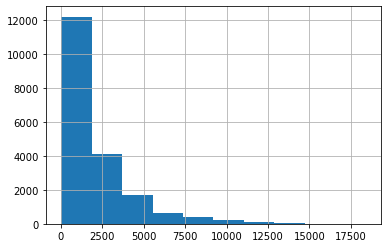

In [13]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Отберём данные для медианны и расчитаем её:
medianna = data.loc[(data['days_employed'] > 0) & (data['days_employed'] < 50000), 'days_employed'].median()
# Заменим аномальные значения на расчитанную медианну:
data.loc[(data['days_employed'] > 50000), 'days_employed'] = medianna
# Просмотрим гистограмму на основе обновлённых данных:
display(data['days_employed'].hist())

##### Проверка столбца `dob_years`

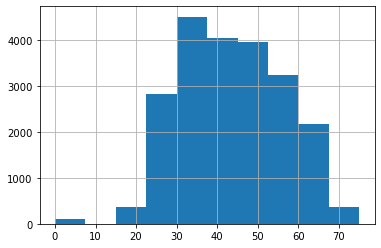

In [14]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Проверим возразт клиентов
display(data['dob_years'].hist())

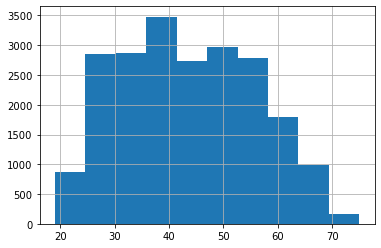

In [15]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Отберём данные для медианны и расчитаем её:
medianna = data.loc[data['dob_years'] > 0, 'dob_years'].median()
medianna
# Заменим аномальные значения на расчитанную медианну:
data.loc[(data['dob_years'] == 0), 'dob_years'] = medianna
# Просмотрим гистограмму на основе обновлённых данных:
display(data['dob_years'].hist())

#### Проверка столбца `education_id`
Столбец 'education_id' содержит категориальные данные, и содержит ограниченное число уникальных значений. Выведем количество упоминаний в столбце для каждого значения.

In [16]:
display(data['education_id'].value_counts())

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

In [17]:
# Посмотрим какое образование скрывается за цифрой 4 (слишком малое количество):
display(data[data['education_id'] == 4])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2963,0,1630.019381,69.0,Ученая степень,4,женат / замужем,0,M,пенсионер,0,98752.495442,покупка жилой недвижимости
4170,0,409.200149,45.0,УЧЕНАЯ СТЕПЕНЬ,4,Не женат / не замужем,4,M,сотрудник,0,198570.757322,операции с коммерческой недвижимостью
6551,0,5352.038180,58.0,ученая степень,4,женат / замужем,0,M,сотрудник,0,268411.214536,заняться высшим образованием
12021,3,5968.075884,36.0,ученая степень,4,женат / замужем,0,F,госслужащий,0,111392.231107,покупка жилья
12786,0,1630.019381,62.0,ученая степень,4,женат / замужем,0,F,пенсионер,0,255425.196556,покупка жилой недвижимости
21519,1,2351.431934,37.0,ученая степень,4,в разводе,3,M,сотрудник,0,115949.039788,покупка коммерческой недвижимости


"Учёная степень" - вполне может быть у заёмщика.

#### Проверка столбца `children`
Столбец 'children' содержит ограниченное число 
уникальных значений. Выведем количество упоминаний в столбце
для каждого значения.

In [18]:
display(data['children'].value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Количество детей -1 не может быть. Скорее всего, сыграл роль человеческий фактор и по ошибке вместо 1 записали -1, поэтому заменим -1 на 1. Количество детей равное 20 - аномально, причём такое количество детей встречается чаще чем количество детей равное 4 и 5 вместе взятых. Предполагаю, также сыграл свою роль человеческий фактор: вместо 2 записали 20, также заменим 20 на 2.

In [19]:
data.loc[data['children'] == -1, 'children'] = 1
data.loc[data['children'] == 20, 'children'] = 2
display(data['children'].value_counts())

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

#### Проверка столбца `family_status_id`
Столбец `family_status_id` содержит категориальные данные.
Выведем количество упоминаний в столбце для каждого значения:

In [20]:
display(data['family_status_id'].value_counts())

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

#### Проверка столбца `total_income`
Проверим доход клиента - должен быть не отрицательным

In [21]:
display(data.loc[data['total_income'] < 0, 'total_income'].sort_values())

Series([], Name: total_income, dtype: float64)

#### Проверка столбца `debt`
Столбец `debt` содержит категориальные данные.
Выведем количество упоминаний в столбце для каждого значения:

In [22]:
display(data['debt'].value_counts())

0    19784
1     1741
Name: debt, dtype: int64

#### Проверка столбцов с нечисловыми значениями
Проверим на регистр столбцы с типом данных object: `education`, `purpose`.

In [23]:
display(data['education'].value_counts())

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Все значения - строковые. Неявные дубликаты уберём на шаге 2.4.

In [24]:
display(data['purpose'].value_counts()) # аномалий не обнаружено

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Все столбцы проверены на аномалии и устранены. 

### Шаг 2.3. Изменение типов данных.

In [25]:
# Изменим тип данных в столбце 'total_income' на integer:
data = data.astype({'total_income': int})
display(data.head(5))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.422610,33.0,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,1630.019381,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


### Шаг 2.4. Удаление дубликатов.

#### Проверим строки на дубликаты:

In [26]:
# Посмотрим на строки дубликаты, если таковые есть:
display(data[data.duplicated()].head(5))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,NaN,41.0,среднее,1,женат / замужем,0,F,сотрудник,0,145017,покупка жилья для семьи
4182,1,NaN,34.0,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,145017,свадьба
4851,0,NaN,60.0,среднее,1,гражданский брак,1,F,пенсионер,0,145017,свадьба
5557,0,NaN,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,145017,сыграть свадьбу
7808,0,NaN,57.0,среднее,1,гражданский брак,1,F,пенсионер,0,145017,на проведение свадьбы


Явно заметно совпадение по столбцам days_employed, total_income - все медианные значения. По остальным столбцам много не совпадений и возможно есть точные совпадения строк. Но это не гарантирует от чистого совпадения данных, т.к. в таблице не представлен уникальный id клиента к примеру. Найдём 100% совпадения по строкам:

In [27]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
duplicats = data[data.duplicated()] # Датафрейм в котором могут содержаться 100%-ные дубликаты
display(duplicats[duplicats.duplicated(keep=False)])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10864,0,NaN,62.0,среднее,1,женат / замужем,0,F,пенсионер,0,145017,ремонт жилью
10994,0,NaN,62.0,среднее,1,женат / замужем,0,F,пенсионер,0,145017,ремонт жилью
16176,0,NaN,47.0,среднее,1,женат / замужем,0,F,сотрудник,0,145017,ремонт жилью
21132,0,NaN,47.0,среднее,1,женат / замужем,0,F,сотрудник,0,145017,ремонт жилью


In [28]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
data.drop(data.index[[10994, 21132]], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21523 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21523 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21523 non-null  float64
 3   education         21523 non-null  object 
 4   education_id      21523 non-null  int64  
 5   family_status     21523 non-null  object 
 6   family_status_id  21523 non-null  int64  
 7   gender            21523 non-null  object 
 8   income_type       21523 non-null  object 
 9   debt              21523 non-null  int64  
 10  total_income      21523 non-null  int32  
 11  purpose           21523 non-null  object 
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 2.1+ MB


In [29]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
data = data.reset_index(drop=True)
display(data.tail(5))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21518,1,4529.316663,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21519,0,1630.019381,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21520,1,2113.346888,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21521,3,3112.481705,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля
21522,2,1984.507589,40.0,среднее,1,женат / замужем,0,F,сотрудник,0,82047,на покупку автомобиля


#### Уберём неявные дубликаты из столбца `education`:

In [30]:
# приведём всё к нижнему регистуру
data['education'] = data['education'].str.lower()
display(data['education'].unique())

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

#### Сформируем датафрейм `education_dict`:

In [31]:
education_dict = data[['education', 'education_id']]
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
education_dict = education_dict.set_index('education_id') # Установили как индекс 'education_id'
display(education_dict)

,education
education_id,
0,высшее
1,среднее
2,неоконченное высшее
3,начальное
4,ученая степень


#### Сформируем датафрейм `family_dict`:

In [32]:
family_dict = data[['family_status', 'family_status_id']]
family_dict = family_dict.drop_duplicates().reset_index(drop=True)
family_dict = family_dict.set_index('family_status_id') # Установили как индекс 'family_status_id'
display(family_dict)

,family_status
family_status_id,
0,женат / замужем
1,гражданский брак
2,вдовец / вдова
3,в разводе
4,Не женат / не замужем


In [33]:
data = data.drop(['education', 'family_status'], axis=1)
# Удалили столбцы 'education', 'family_status'

### Шаг 2.6. Категоризация дохода.

In [34]:
# Для начала создадим функцию, которая возвращает категорию в зависимости от дохода
def get_income_category(income):
    ''' Доходы поделим по категориям:
        0–30000 — 'E';
        30001–50000 — 'D';
        50001–200000 — 'C';
        200001–1000000 — 'B';
        1000001 и выше — 'A'.'''
    if income <= 30000:
        return 'E'
    if income <= 50000:
        return 'D'
    if income <= 200000:
        return 'C'
    if income <= 1000000:
        return 'B'
    return 'A'

# Добавим новый столбец 'total_income_category'
data['total_income_category'] = data['total_income'].apply(get_income_category)
display(data.head(5))

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437.673028,42.0,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024.803754,36.0,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623.422610,33.0,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124.747207,32.0,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,1630.019381,53.0,1,1,F,пенсионер,0,158616,сыграть свадьбу,C


### Шаг 2.7. Категоризация целей кредита.

In [35]:
# Cоздадим функцию, которая возвращает категорию в зависимости от целей кредита
def get_purpose_category(purpose):
    ''' Цели поделим по категориям:
        'операции с автомобилем',
        'операции с недвижимостью',
        'проведение свадьбы',
        'получение образования'.'''
    if 'автомобил' in purpose:
        return 'операции с автомобилем'
    if 'жиль' in purpose or 'недвижимост' in purpose:
        return 'операции с недвижимостью'
    if 'свадьб' in purpose:
        return 'проведение свадьбы'
    if 'образова' in purpose:
        return 'получение образования'

# Добавим новый столбец 'total_purpose_category'
data['purpose_category'] = data['purpose'].apply(get_purpose_category)
display(data.head(5))

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437.673028,42.0,0,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024.803754,36.0,1,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623.422610,33.0,1,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124.747207,32.0,1,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,1630.019381,53.0,1,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


### Ответы на вопросы.

In [36]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
data_copy = data.copy() # создадим копию датафрейма 'data' для экспериментов

##### Вопрос 1:
Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [37]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Создадим сводную таблицу со столбцами "0" - нет задолжности, "1" - есть задолжность. В строках будут категории заёмщиков. 
data_children = data_copy.pivot_table(index='children', columns='debt', values='dob_years', aggfunc='count')
display(data_children)

debt,0,1
children,,
0,13084.0,1063.0
1,4420.0,445.0
2,1929.0,202.0
3,303.0,27.0
4,37.0,4.0
5,9.0,NaN


Выборка по клиентам с 5 и 4 детьми не репрезентативна, объеденим эту группу клиентов с группой клиентов с 3 детьми и посмотрим получившиеся результаты.

In [38]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
data_copy['children'] = data_copy['children'].astype(str) # Изменим тип данных в столбце 'children' на строковый
# Объединим в одну категорию клиентов с тремя и более детьми
data_copy.loc[(data_copy['children'] == '4') | (data_copy['children'] == '5') | (data_copy['children'] == '3'), 'children'] = '3+'
data_children = data_copy.pivot_table(index='children', columns='debt', values='dob_years', aggfunc='count')
display(data_children)

debt,0,1
children,,
0,13084,1063
1,4420,445
2,1929,202
3+,349,31


##### Вывод 1:

In [39]:
# Добавим столбец `part_debt` в котором покажем долю должников по категориям
data_children['part_debt'] = data_children[1] / (data_children[0] + data_children[1]) 
display(data_children.sort_values(by='part_debt'))  # cортируем по возрастанию

debt,0,1,part_debt
children,,,
0,13084,1063,0.075140
3+,349,31,0.081579
1,4420,445,0.091470
2,1929,202,0.094791


Зависимость количества детей на возврать кредита:
клиенты без детей более дисциплинированы, чем клиенты с детьми.
1. По столбцу `part_debt` видим, что **наиболее** дисциплинированные **клиенты без детей**. 
2. Следом идут клиенты у которыех **3 и более детей**. 
3. **Наименее** дисциплинированы клиенты с **одним или двумя детьми**. 

##### Вопрос 2:
Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [40]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Создадим сводную таблицу со столбцами "0" - нет задолжности, "1" - есть задолжность. В строках будут категории заёмщиков. 
data_family = data_copy.pivot_table(index='family_status_id', columns='debt', values='dob_years', aggfunc='count')
display(data_family)
# Заменим "family_status_id" на соответствующий "family status" from 'family_dict'.
data_family = data_family.rename(index=family_dict['family_status'])
display(data_family)

debt,0,1
family_status_id,,
0,11447,931
1,3789,388
2,897,63
3,1110,85
4,2539,274


debt,0,1
family_status_id,,
женат / замужем,11447,931
гражданский брак,3789,388
вдовец / вдова,897,63
в разводе,1110,85
Не женат / не замужем,2539,274


#### Вывод 2:

In [41]:
data_family['part_debt'] = data_family[1] / (data_family[0] + data_family[1])
display(data_family.sort_values('part_debt'))

debt,0,1,part_debt
family_status_id,,,
вдовец / вдова,897,63,0.065625
в разводе,1110,85,0.071130
женат / замужем,11447,931,0.075214
гражданский брак,3789,388,0.092890
Не женат / не замужем,2539,274,0.097405


Есть зависимость от семейного положения.
Из полученной таблицы видно:
1. **Лучшая** кредитная дисциплина у клиентов указавших статус **"вдовец / вдова"**.
2. **Худшая** кредитная дисциплина у клиентов указавших статус **"Не женат / не замужем"**.

#### Вопрос 3:
Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [42]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Создадим сводную таблицу со столбцами "0" - нет задолжности, "1" - есть задолжность. В строках будут категории заёмщиков. 
data_income = data_copy.pivot_table(index='total_income_category', columns='debt', values='dob_years', aggfunc='count')
display(data_income)

debt,0,1
total_income_category,,
A,23,2
B,4685,356
C,14725,1360
D,329,21
E,20,2


Категории "А" и "Е" слишком малы, поэтому соединим их с категориями "В" и "D" соответственно.

In [43]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
data_copy.loc[data_copy['total_income_category'] == 'A', 'total_income_category'] = 'B'
data_copy.loc[data_copy['total_income_category'] == 'E', 'total_income_category'] = 'D' 
data_income = data_copy.pivot_table(index='total_income_category', columns='debt', values='dob_years', aggfunc='count')
display(data_income)

debt,0,1
total_income_category,,
B,4708,358
C,14725,1360
D,349,23


#### Вывод 3:

In [44]:
# Добавим столбец 'part_debt'
data_income['part_debt'] = data_income[1] / (data_income[0] + data_income[1])
display(data_income.sort_values(by='part_debt'))

debt,0,1,part_debt
total_income_category,,,
D,349,23,0.061828
B,4708,358,0.070667
C,14725,1360,0.084551


Есть зависимость между уровнем дохода и возвратом кредита в срок:
1. **Лучшие заёмщики** - клиенты с уровнем дохода **до 50000**
2. **Худшие заёмщики** - клиенты с уровнем дохода в диапазоне: **50001–200000**.

#### Вопрос 4:
Как разные цели кредита влияют на его возврат в срок?

In [45]:
# ИЗМЕНЕНО ПОСЛЕ РЕВЬЮ
# Создадим сводную таблицу со столбцами "0" - нет задолжности, "1" - есть задолжность. В строках будут категории заёмщиков. 
data_target = data_copy.pivot_table(index='purpose_category', columns='debt', values='dob_years', aggfunc='count')
display(data_target)

debt,0,1
purpose_category,,
операции с автомобилем,3912,403
операции с недвижимостью,10056,782
получение образования,3652,370
проведение свадьбы,2162,186


#### Вывод 4:

In [46]:
# Добавим столбец 'part_debt'
data_target ['part_debt'] = data_target [1] / (data_target [0] + data_target [1])
display(data_target.sort_values(by='part_debt'))

debt,0,1,part_debt
purpose_category,,,
операции с недвижимостью,10056,782,0.072154
проведение свадьбы,2162,186,0.079216
получение образования,3652,370,0.091994
операции с автомобилем,3912,403,0.093395


По целям произошло деление на **две группы**:
1. **Хорошо** возвращают кредиты клиенты из категорий **"операции с недвижимостью", "проведение свадьбы"**.
2. **Хуже** всего возвращают кредиты клиенты из категорий **"получение образования", "операции с автомобилем"**.

## Общий вывод:

Наименее дисциплинированные заёмщики это: 
- клиенты с целями кредита: "получение образования", "операции с автомобилем";
- клиенты с доходом в диапазоне 50001-200000;
- клиенты, указавшие семейное положение "Не женат / не замужем";
- клиенты с одним или двумя детьми.

Хорошими заёмщиками с большой вероятностью могут быть:
- клиенты, указавшие семейное положение: "вдовец / вдова", "в разводе", "женат / не замужем";
- клиенты с доходом до 50000;
- клиенты с целями кредита: "операции с недвижимостью", "проведение свадьбы"; 
- клиенты без детей.